# Start: Analysiere Daten

In [58]:
# import initial_data.csv
import pandas as pd
import numpy as np

from feasibility import is_feasible

# import data from csv file
def import_data():
    data = pd.read_csv('initial_data.csv')
    return data

data = import_data()

In [59]:
# put column names into a list
column_names = data.columns.values
print(column_names)
inputs = column_names[0:8]
print(inputs)
outputs = column_names[8:13]
print(outputs)

['Engine speed' 'Engine load' 'Railpressure' 'Air supply' 'Crank angle'
 'Intake pressure' 'Back pressure' 'Intake temperature' 'NOx' 'PM 1' 'CO2'
 'PM 2' 'Pressure cylinder']
['Engine speed' 'Engine load' 'Railpressure' 'Air supply' 'Crank angle'
 'Intake pressure' 'Back pressure' 'Intake temperature']
['NOx' 'PM 1' 'CO2' 'PM 2' 'Pressure cylinder']


In [96]:
def get_input_data(data, row):
    x1, x2, x3, x4, x5, x6, x7, x8 = data.iloc[row, 0], data.iloc[row, 1], data.iloc[row, 2], data.iloc[row, 3], data.iloc[row, 4], data.iloc[row, 5], data.iloc[row, 6], data.iloc[row, 7]
    return x1, x2, x3, x4, x5, x6, x7, x8

def get_output_data(row):
    x1, x2, x3, x4, x5 = data.iloc[row, 8], data.iloc[row, 9], data.iloc[row, 10], data.iloc[row, 11], data.iloc[row, 12]
    return x1, x2, x3, x4, x5

def get_critical_output_data(i):
    x1, x2, x3 = data.iloc[i, 9], data.iloc[i, 11], data.iloc[i, 12]
    return x1, x2, x3

In [61]:
# show if data row is feasible via the first 8 columns and the function is_feasible
feasible = []
for i in range(len(data)):
    x1, x2, x3, x4, x5, x6, x7, x8 = get_input_data(data, i)
    # print(x1, x2, x3, x4, x5, x6, x7, x8)
    feasible.append(is_feasible(x1, x2, x3, x4, x5, x6, x7, x8))
data['feasible'] = feasible

In [78]:
# Check if outputs are in safe range
# PM 1 < 6, PM 2 < 16, Pressure cylinder < 160

def label_safe(data):
    safe = []
    for i in range(len(data)):
        x9, x10, x11 = get_critical_output_data(i)
        if x9 < 6 and x10 < 16:
            if x11 < 160:
                safe.append(0)
            else:
                safe.append(2)
        else:
            if x11 < 160:
                safe.append(1)
            else:
                safe.append(2)
    data['safe'] = safe
    return data

data = label_safe(data)

In [86]:
unsafe_params = [5, 13, 130]

# label broader safe range
def label_broader_safe(data):
    safe = []
    for i in range(len(data)):
        x9, x10, x11 = get_critical_output_data(i)
        if x9 < unsafe_params[0] and x10 < unsafe_params[1]:
            if x11 < unsafe_params[2]:
                safe.append(0)
            else:
                safe.append(2)
        else:
            if x11 < unsafe_params[2]:
                safe.append(1)
            else:
                safe.append(2)
    data['broader_safe'] = safe
    return data

data = label_broader_safe(data)

# count number of False values in safe column
print((len(data[data['broader_safe'] == 1])+len(data[data['broader_safe'] == 2])))

12


In [91]:
# show unsafe data (safe == 1 or safe == 2)
unsafe_data = data[(data['broader_safe'] == 1) | (data['broader_safe'] == 2)]
print(unsafe_data)

    Engine speed  Engine load  Railpressure  Air supply  Crank angle  \
39        1300.0        64.88        1798.9    297.1093        -2.89   
46        1400.0        73.39        1887.8    358.3535        -3.64   
62        1600.0       135.17        2195.4    740.8542         1.39   
68        1700.0       135.93        2298.3    793.9227         2.31   
70        1800.0        35.66        1521.7    310.5600         5.69   
74        1800.0       122.01        2401.4    787.3758         2.40   
75        1800.0       145.02        2378.4    885.3311         2.72   
81        1900.0       115.29        2499.3    800.7886         3.08   
82        1900.0       138.39        2499.3    922.4504         2.94   
88        2000.0       116.28        2499.9    875.2752         3.49   
89        2000.0       139.54        2500.3   1008.3008         3.66   
95        2100.0       124.97        2500.1   1010.2031         4.27   

    Intake pressure  Back pressure  Intake temperature         

In [94]:
# train a model to predict unsafe output
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# split data into training and testing data
X = data[inputs]
y = data['broader_safe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# count number of False values in y_train and y_test
print("Number of unsafe in training: ",(len(y_train[y_train == 1])+len(y_train[y_train == 2])))
print("Number of unsafe in testing: ",(len(y_test[y_test == 1])+len(y_test[y_test == 2])))

print("Parameters for unsafe data: ")
print("PM 1: ", unsafe_params[0])
print("PM 2: ", unsafe_params[1])
print("Pressure cylinder: ", unsafe_params[2])

# train a random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# predict on test data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Number of unsafe in training:  10
Number of unsafe in testing:  2
Parameters for unsafe data: 
PM 1:  5
PM 2:  13
Pressure cylinder:  130
Accuracy: 0.9


In [93]:
# submission.csv
def import_submission():
    submission = pd.read_csv('submission.csv')
    return submission

submission = import_submission()

In [97]:
# show if data row is feasible via the first 8 columns and the function is_feasible
feasible = []
for i in range(len(submission)):
    x1, x2, x3, x4, x5, x6, x7, x8 = get_input_data(submission,i)
    # print(x1, x2, x3, x4, x5, x6, x7, x8)
    feasible.append(is_feasible(x1, x2, x3, x4, x5, x6, x7, x8))
submission['feasible'] = feasible

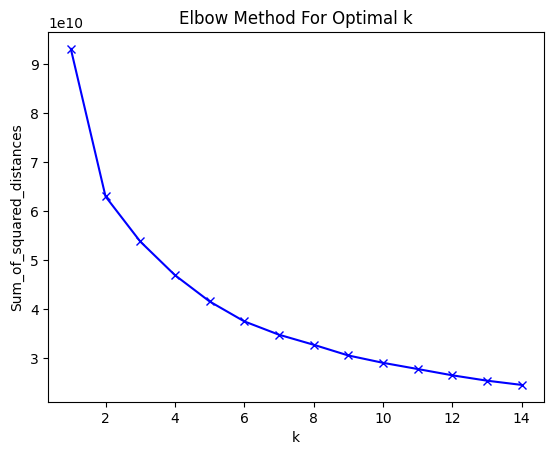

In [70]:
# find the area with the most data points via k-means clustering
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# find number of clusters via elbow method
Sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(submission)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [104]:
# k-Means Clustering durchführen
kmeans = KMeans(n_clusters=6)  # s.o.: 6 Cluster
kmeans.fit(submission)
labels = kmeans.labels_

# Format of print without exponential
np.set_printoptions(suppress=True)

# Größten Cluster finden
# unique, counts = np.unique(labels, return_counts=True)
# groesster_cluster_index = np.argmax(counts)
# groesster_cluster = submission[labels == groesster_cluster_index]

# Bereich des größten Clusters bestimmen (durch Mittelpunkt und Streuung)
# mittelpunkt = kmeans.cluster_centers_[groesster_cluster_index]
# max_distanz = np.max(np.sqrt(np.sum((groesster_cluster - mittelpunkt)**2, axis=1)))

# print(f"Mittelpunkt des größten Clusters: {mittelpunkt}")
# print(f"Maximale Distanz vom Mittelpunkt: {max_distanz}")

# Größe aller Cluster ausgeben mit deren Mittelpunkt und Streuung
allClusters = []
for i in range(6):
    cluster = submission[labels == i]
    mittelpunkt = kmeans.cluster_centers_[i]
    streuung = np.max(np.sqrt(np.sum((cluster - mittelpunkt)**2, axis=1)))
    # get the ranges of the clusters
    min_value = np.min(cluster, axis=0)
    max_value = np.max(cluster, axis=0)
    allClusters.append((i, len(cluster), mittelpunkt, streuung, min_value, max_value))
    print(f"Cluster {i}: {len(cluster)} Datenpunkte, Mittelpunkt: {mittelpunkt}, Streuung: {streuung}, Min: + Max: (Range)")

Cluster 0: 9914 Datenpunkte, Mittelpunkt: [1195.16459381   62.70487214 1186.53801027  472.47529944   -0.56454114
 2563.86568832 1905.69326218   56.35841732    1.        ], Streuung: 1401.551663936645, Min: + Max: (Range)
Cluster 1: 9920 Datenpunkte, Mittelpunkt: [1678.42649037   80.10056747 1677.03559642  653.04175388    0.2402296
 2634.83993557 3307.59341327   58.08492258    1.        ], Streuung: 1478.640662403804, Min: + Max: (Range)
Cluster 2: 10899 Datenpunkte, Mittelpunkt: [1037.44287445   55.77027482 1094.8070731   414.15337285   -0.7956801
 1901.43229242 3313.51335932   55.74604873    1.        ], Streuung: 1405.6012494536915, Min: + Max: (Range)
Cluster 3: 9391 Datenpunkte, Mittelpunkt: [1868.90588205   69.45969345 2027.30241711  712.27449918    0.66475872
 2164.0042151  1876.92838217   58.02332286    1.        ], Streuung: 1544.2928626853402, Min: + Max: (Range)
Cluster 4: 9657 Datenpunkte, Mittelpunkt: [1217.03032171   51.83910309 1215.57495419  468.13248207   -0.53457201
 1

In [76]:
# generate random data points in the range of the largest cluster
import random
random_data = []
for i in range(10):
    random_data.append([
        random.uniform(groesster_cluster.min()[0], groesster_cluster.max()[0]),
        random.uniform(groesster_cluster.min()[1], groesster_cluster.max()[1]),
        random.uniform(groesster_cluster.min()[2], groesster_cluster.max()[2]),
        random.uniform(groesster_cluster.min()[3], groesster_cluster.max()[3]),
        random.uniform(groesster_cluster.min()[4], groesster_cluster.max()[4]),
        random.uniform(groesster_cluster.min()[5], groesster_cluster.max()[5]),
        random.uniform(groesster_cluster.min()[6], groesster_cluster.max()[6]),
        random.uniform(groesster_cluster.min()[7], groesster_cluster.max()[7])
    ])
print(random_data)

[[1997.8121513224614, 112.91547887925219, 1645.603139454999, 882.6126624300058, 5.033640047671298, 3007.3658892579892, 2534.258979984933, 72.51886978878605], [1908.404515333474, 18.111656987485343, 2131.5816622721386, 1090.8254882136087, 9.014417345688106, 1903.9834205224897, 1972.0242756293405, 62.77266687333263], [1254.5101207672237, 26.885720493715144, 2655.8731723941605, 1338.3760914642583, 0.7982886240733063, 1334.3885275628606, 1087.1119620508875, 44.10760511663168], [1896.7385696022025, 97.53841938052071, 907.7598856937068, 1126.456420378956, 1.300510024663362, 1503.3333751317473, 1963.603399431302, 68.10102072370529], [1729.127415408652, 34.60317369376545, 2608.647684727711, 555.1063363203986, 11.887857563402505, 1126.3805985988427, 1375.5257946231418, 41.94777435725728], [1079.9359423883986, 23.724396668033094, 1725.9281544130308, 324.95627600401076, 1.3768187352387482, 965.4242640039353, 2343.552328412761, 46.92378817208487], [1279.1320410461237, 132.26124603496623, 2249.1516

/var/folders/t3/x97qqmj14s9dfss7rn927cvh0000gn/T/ipykernel_39364/2753382777.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  random.uniform(groesster_cluster.min()[0], groesster_cluster.max()[0]),
/var/folders/t3/x97qqmj14s9dfss7rn927cvh0000gn/T/ipykernel_39364/2753382777.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  random.uniform(groesster_cluster.min()[1], groesster_cluster.max()[1]),
/var/folders/t3/x97qqmj14s9dfss7rn927cvh0000gn/T/ipykernel_39364/2753382777.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels

In [95]:
# predict safe or unsafe for the cluster center
print(clf.predict([mittelpunkt])) # 0 means safe, 1 means semi-safe, 2 means dangerous--> 0

# predict safe or unsafe for the random data points
print(clf.predict(random_data)) # True means safe, False means unsafe --> True

[0]
[2 0 0 0 0 0 0 0 0 0]


/Users/lauraschone/Desktop/repos/force-push/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/lauraschone/Desktop/repos/force-push/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


random data:


[[1997.8121513224614, 112.91547887925219, 1645.603139454999, 882.6126624300058, 5.033640047671298, 3007.3658892579892, 2534.258979984933, 72.51886978878605], 

[1908.404515333474, 18.111656987485343, 2131.5816622721386, 1090.8254882136087, 9.014417345688106, 1903.9834205224897, 1972.0242756293405, 62.77266687333263], 

[1254.5101207672237, 26.885720493715144, 2655.8731723941605, 1338.3760914642583, 0.7982886240733063, 1334.3885275628606, 1087.1119620508875, 44.10760511663168], 

[1896.7385696022025, 97.53841938052071, 907.7598856937068, 1126.456420378956, 1.300510024663362, 1503.3333751317473, 1963.603399431302, 68.10102072370529], 

[1729.127415408652, 34.60317369376545, 2608.647684727711, 555.1063363203986, 11.887857563402505, 1126.3805985988427, 1375.5257946231418, 41.94777435725728], 

[1079.9359423883986, 23.724396668033094, 1725.9281544130308, 324.95627600401076, 1.3768187352387482, 965.4242640039353, 2343.552328412761, 46.92378817208487], 

[1279.1320410461237, 132.26124603496623, 2249.1516003111865, 495.1745067782021, -6.945592354331936, 1801.2109081987455, 1049.1644783837996, 57.918065698571525], 

[2164.2569867385682, 137.26393122593197, 1947.9005596768827, 1031.4685267120751, 1.163226081750972, 2523.4601498486713, 1426.1548474431202, 46.70186166090589], 

[2242.173858147647, 92.68592800615727, 2694.1846715532365, 1226.928802020495, 3.749003952951746, 1897.9095172658251, 2387.923942121591, 55.231427190545304], 

[1616.889790075234, 102.7086362819355, 2148.9778340197013, 894.4063700884818, 3.411177017584235, 1331.1569291363887, 2284.992228431832, 39.13888079847329]]
